In [78]:
import numpy as np
from collections import defaultdict
from typing import Dict
from collections import deque
import sys

In [79]:
#Importing Ml agents packages
import mlagents as mlg
from mlagents_envs.environment import UnityEnvironment as UE

In [95]:
env = UE(file_name='../SingleAgentStaticGoal/ModelTraining',seed=1,side_channels=[])

In [96]:
env.reset()
behavior_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behavior_name]

In [97]:
spec.observation_specs[0].shape
spec.action_spec.discrete_branches

(3, 3, 2)

In [76]:
# decision_steps, terminal_steps = env.get_steps(behavior_name)
# tracked_agent = decision_steps.agent_id[0]
# env.reset()

In [98]:
class Action():

    def __init__(self,b,a=None):
        self.ca = a
        self.da = b
        
    @property
    def continuous(self):
        return self.ca

    @property
    def discrete(self):
        return self.da

In [99]:
# Epsillon greedy
def e_greedy(Q, state, epsilon):
    if np.random.random() > epsilon:
        action = np.array([np.unravel_index(np.argmax(Q[state]), Q[state].shape)])
    else : 
        action = np.array([[np.random.randint(0,3),np.random.randint(0,3),np.random.randint(0,2)]],dtype=np.int64)
    return Action(action,np.zeros((1,0)))

In [100]:
def Update_Q_value(Q_table,alpha, gamma, state, action, reward, next_state):
    max_f_Q = np.max(Q_table[next_state])
    current_value = Q_table[state][action.discrete[0][0],action.discrete[0][1],action.discrete[0][2]]
    new_Q = (1-alpha) * current_value + alpha * (reward + gamma * max_f_Q)
    return new_Q

In [101]:
X = np.zeros((3,3))
X[2][2] = 9
np.unravel_index(np.argmax(X), X.shape),X

((2, 2),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 9.]]))

In [102]:
np.zeros((1,0))
nA = env.behavior_specs[behavior_name].action_spec.discrete_branches
Q1 = defaultdict(lambda: np.zeros(nA))
action = np.array([[np.random.randint(0,3),np.random.randint(0,3),np.random.randint(0,2)]],dtype=np.int64)
acc = Action(action,np.zeros((1,0)))
Q1[0][acc.discrete[0][0],acc.discrete[0][1],acc.discrete[0][2]] = 20


In [103]:
def Q_learning(num_episodes, alpha, gamma=0.95):
   SHOW_STATS = 5
   epsillon = 0.5
   START_EPSILLON_DECAYING = 1
   EPISODES = num_episodes
   END_EPSILLON_DECAYING = EPISODES//2
   ep_reward = []
   agg_ep_reward = {'ep':[],'avg':[],'min':[],'max':[]}

   epsilon_decay_value = epsillon/(END_EPSILLON_DECAYING - START_EPSILLON_DECAYING)
   nA = env.behavior_specs[behavior_name].action_spec.discrete_branches
   Q = defaultdict(lambda: np.zeros(nA))
   for i in range(1,num_episodes+1):
      env.reset()
      decision_steps, terminal_steps = env.get_steps(behavior_name)
      tracked_agent = -1
      done = False
      episode_rewards = 0
      state = tuple(map(tuple, o) for o in decision_steps.obs)
      while not done:
         if tracked_agent == -1 and len(decision_steps) >= 1:
            tracked_agent = decision_steps.agent_id[0]
         
         action = e_greedy(Q,state,epsillon)
            
         env.set_action_for_agent(behavior_name=behavior_name,agent_id=tracked_agent,action=action)
         # q_table[ds + (action,)] = new_Q
         env.step()

         decision_steps, terminal_steps = env.get_steps(behavior_name)
         new_state = tuple(map(tuple, o) for o in decision_steps.obs)
         if tracked_agent in decision_steps: # The agent requested a decision
            reward = decision_steps[tracked_agent].reward
            episode_rewards += reward
            new_Q = Update_Q_value(Q ,alpha,gamma,state,action,reward,new_state)
            Q[state][action.discrete[0][0],action.discrete[0][1],action.discrete[0][2]] = new_Q
            state = new_state
         if tracked_agent in terminal_steps: # The agent terminated its episode
            episode_rewards += terminal_steps[tracked_agent].reward
            if END_EPSILLON_DECAYING >= i >= START_EPSILLON_DECAYING:
                epsillon -= epsilon_decay_value
            done = True
            print(f"Total rewards for episode {i} is {episode_rewards}")
            break
      ep_reward.append(episode_rewards)
      if not i % SHOW_STATS:
        average_reward = sum(ep_reward[-SHOW_STATS:])/len(ep_reward[-SHOW_STATS:])
        agg_ep_reward['ep'].append(i)
        agg_ep_reward['avg'].append(average_reward)
        agg_ep_reward['min'].append(min(ep_reward[-SHOW_STATS:]))
        agg_ep_reward['max'].append(max(ep_reward[-SHOW_STATS:]))

   return Q,ep_reward,agg_ep_reward

In [104]:
Q_table, total_rewards,agg_ep_reward = Q_learning(30,0.1)

Total rewards for episode 1 is -1.0
Total rewards for episode 2 is 5.0
Total rewards for episode 3 is 4.0
Total rewards for episode 4 is 2.0
Total rewards for episode 5 is -1.0
Total rewards for episode 6 is -1.0
Total rewards for episode 7 is 0.0
Total rewards for episode 8 is -1.0
Total rewards for episode 9 is -1.0
Total rewards for episode 10 is -1.0
Total rewards for episode 11 is 4.0
Total rewards for episode 12 is -1.0
Total rewards for episode 13 is 0.0
Total rewards for episode 14 is 0.0
Total rewards for episode 15 is 0.0
Total rewards for episode 16 is -3.0
Total rewards for episode 17 is 0.0
Total rewards for episode 18 is 0.0
Total rewards for episode 19 is 0.0
Total rewards for episode 20 is 0.0
Total rewards for episode 21 is 0.0
Total rewards for episode 22 is 0.0
Total rewards for episode 23 is 0.0


KeyboardInterrupt: 

In [68]:
import matplotlib.pyplot as plt

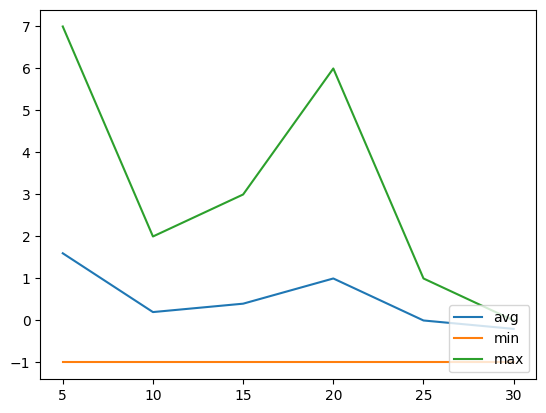

In [76]:
plt.plot(agg_ep_reward['ep'],agg_ep_reward['avg'],label="avg")
plt.plot(agg_ep_reward['ep'],agg_ep_reward['min'],label="min")
plt.plot(agg_ep_reward['ep'],agg_ep_reward['max'],label="max")
plt.legend(loc = 4)
plt.show()

In [10]:
for i in range(100):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    tracked_agent = -1
    done = False
    episode_rewards = 0
    while not done:
      if tracked_agent == -1 and len(decision_steps) >= 1:
         tracked_agent = decision_steps.agent_id[0]

      action = Action(np.array([[np.random.randint(0,3),np.random.randint(0,3),np.random.randint(0,3)]],dtype=np.int32),np.zeros((1,0)))
      env.set_action_for_agent(behavior_name=behavior_name,agent_id=tracked_agent,action=action)
      env.step()

      decision_steps, terminal_steps = env.get_steps(behavior_name)
      if tracked_agent in decision_steps: # The agent requested a decision
         episode_rewards += decision_steps[tracked_agent].reward
      if tracked_agent in terminal_steps: # The agent terminated its episode
         episode_rewards += terminal_steps[tracked_agent].reward
         done = True
      print(f"Total rewards for episode {i} is {episode_rewards}")

Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is 0.0
Total rewards for episode 0 is -1.0
Total rewards for episode 1 is 0.0
Total rewards for episode 1 is -1.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for episode 2 is 0.0
Total rewards for 

In [94]:
env.close()